# 1.6 signac-flow HOOMD-blue Example

## About

This notebook contains a minimal example for running a *signac-flow* project from scratch.
The example demonstrates how to compare an ideal gas with a Lennard-Jones (LJ) fluid by calculating a p-V phase diagram.

This examples uses the general-purpose simulation toolkit [HOOMD-blue](http://glotzerlab.engin.umich.edu/hoomd-blue/) for the execution of the molecular-dynamics (MD) simulations.

## Author

Carl Simon Adorf, Bradley Dice

## Before you start

This example requires signac, signac-flow, HOOMD-blue, gsd, and numpy.
You can install these package for example via conda:
```
conda install -c conda-forge gsd hoomd numpy signac signac-flow
```

In [1]:
import itertools
import os

import flow
import gsd.hoomd
import hoomd
import numpy as np
import signac

project_path = "projects/tutorial-signac-flow-hoomd"


class MyProject(flow.FlowProject):
    pass

We want to generate a pressure-volume phase diagram for a Lennard-Jones fluid with molecular dynamics (MD) using the general-purpose simulation toolkit HOOMD-blue (http://glotzerlab.engin.umich.edu/hoomd-blue/).

We start by defining two functions, one for the initialization of our simulation and one for the actual execution.

In [2]:
from contextlib import contextmanager
from math import ceil


def init(N):
    frame = gsd.hoomd.Frame()
    frame.particles.N = N
    frame.particles.types = ["A"]
    frame.particles.typeid = np.zeros(N)

    n = ceil(pow(N, 1 / 3))
    assert n**3 == N
    spacing = 1.2
    L = n * spacing
    frame.configuration.box = [L, L, L, 0.0, 0.0, 0.0]
    x = np.linspace(-L / 2, L / 2, n, endpoint=False)
    position = list(itertools.product(x, repeat=3))
    frame.particles.position = position
    with gsd.hoomd.open("init.gsd", "wb") as traj:
        traj.append(frame)


@contextmanager
def get_sim(N, sigma, seed, kT, tau, p, tauP, r_cut):
    sim = hoomd.Simulation(hoomd.device.CPU())
    state_fn = "init.gsd"
    if os.path.exists("restart.gsd"):
        state_fn = "restart.gsd"
    sim.create_state_from_gsd(state_fn)
    sim.operations += hoomd.write.GSD(
        filename="restart.gsd", truncate=True, trigger=100, filter=hoomd.filter.All()
    )
    lj = hoomd.md.pair.LJ(default_r_cut=r_cut, nlist=hoomd.md.nlist.Cell(0.4))
    lj.params[("A", "A")] = {"epsilon": 1.0, "sigma": sigma}
    integrator = hoomd.md.Integrator(
        dt=0.005,
        methods=[
            hoomd.md.methods.NPT(
                filter=hoomd.filter.All(), kT=kT, tau=tau, S=p, tauS=tauP, couple="xyz"
            )
        ],
        forces=[lj],
    )
    sim.operations.integrator = integrator
    logger = hoomd.logging.Logger(categories=("scalar", "string"))
    logger["Volume"] = (lambda: sim.state.box.volume, "scalar")

    # This context manager keeps the log file open while the simulation runs.
    with open("dump.log", "w+") as outfile:
        table = hoomd.write.Table(
            trigger=100, logger=logger, output=outfile, pretty=False
        )
        sim.operations += table
        yield sim

We want to use **signac** to manage our simulation data and **signac-flow** to define a workflow acting on the data space.

Now that we have defined the core simulation logic above, it's time to embed those functions into a general *workflow*.
For this purpose we add labels and operations with preconditions/postconditions to `MyProject`, a subclass of `flow.FlowProject`.

The `estimate` operation stores an ideal gas estimation of the volume for the given system.
The `sample` operation actually executes the MD simulation as defined in the previous cell.

In [3]:
@MyProject.label
def estimated(job):
    return "V" in job.document


@MyProject.label
def sampled(job):
    return job.document.get("sample_step", 0) >= 5000


@MyProject.post(estimated)
@MyProject.operation
def estimate(job):
    sp = job.statepoint()
    job.document["V"] = sp["N"] * sp["kT"] / sp["p"]


@MyProject.post(sampled)
@MyProject.operation
def sample(job):
    with job:
        with get_sim(**job.statepoint()) as sim:
            try:
                sim.run(5_000)
            finally:
                job.document["sample_step"] = sim.timestep

Now it's time to actually generate some data! Let's initialize the data space!


In [4]:
project = MyProject.init_project(project_path)

# Uncomment the following two lines if you want to start over!
# for job in project:
#     job.remove()

for p in np.linspace(0.5, 5.0, 10):
    sp = dict(
        N=512, sigma=1.0, seed=42, kT=1.0, p=float(p), tau=1.0, tauP=1.0, r_cut=2.5
    )
    job = project.open_job(sp).init()
    with job:
        init(N=sp["N"])

The `print_status()` function allows to get a quick overview of our project's *status*:

In [5]:
project.print_status(detailed=True, parameters=["p"])

Fetching status:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching labels:   0%|          | 0/10 [00:00<?, ?it/s]


Overview: 10 jobs/aggregates, 10 jobs/aggregates with eligible operations.

label
-------


operation/group      number of eligible jobs  submission status
-----------------  -------------------------  -------------------
estimate                                  10  [U]: 10
sample                                    10  [U]: 10

Detailed View:

job id                            operation/group      p  labels
--------------------------------  -----------------  ---  --------
18c063206c37ab03d06de130c6ae2b70  estimate [U]       1
                                  sample [U]         1
2a05a487f254db90b08f576d199a83b7  estimate [U]       5
                                  sample [U]         5
4ef567c185064a4b27b73f62124991c0  estimate [U]       3
                                  sample [U]         3
5b3c8f0fbd9458a304222d83bb82bc30  estimate [U]       3.5
                                  sample [U]         3.5
6681f083e2b03f5b9816f35502e411f7  estimate [U]       1.5
                   

The next cell will attempt to execute all eligible operations.

In [6]:
project.run()

/home/bdice/mambaforge/envs/signac-examples/lib/python3.10/site-packages/hoomd/md/methods/methods.py:365: FutureWarning: NPT is deprecated and wil be removed in hoomd 4.0. In version 4.0, use the ConstantPressure method with the desired thermostat from hoomd.md.methods.thermostats.
  warnings.warn(


Let's double check the project status.

In [7]:
project.print_status(detailed=True)

Fetching status:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching labels:   0%|          | 0/10 [00:00<?, ?it/s]


Overview: 10 jobs/aggregates, 0 jobs/aggregates with eligible operations.

label      ratio
---------  ----------------------------------------------------------
estimated  |████████████████████████████████████████| 10/10 (100.00%)
sampled    |████████████████████████████████████████| 10/10 (100.00%)

operation/group
-----------------


Detailed View:

job id                            operation/group    labels
--------------------------------  -----------------  ------------------
18c063206c37ab03d06de130c6ae2b70  [ ]                estimated, sampled
2a05a487f254db90b08f576d199a83b7  [ ]                estimated, sampled
4ef567c185064a4b27b73f62124991c0  [ ]                estimated, sampled
5b3c8f0fbd9458a304222d83bb82bc30  [ ]                estimated, sampled
6681f083e2b03f5b9816f35502e411f7  [ ]                estimated, sampled
6ff6b952b42f0ad3e1315e137cf67cdb  [ ]                estimated, sampled
99f5397cf2f6250afe34927606aa2f37  [ ]                estimated, sampled
a5d4427e

After running all operations we can make a brief examination of the collected data.

In [8]:
def get_volume(job):
    log = np.genfromtxt(job.fn("dump.log"), names=True)
    N = len(log)
    return log[int(0.5 * N) :]["Volume"].mean(axis=0)


for job in project:
    print(job.statepoint["p"], get_volume(job), job.document.get("V"))

2.0 735.545045936 256.0
1.5 798.7716894079999 341.3333333333333
5.0 588.32751952 102.4
3.0 662.30139688 170.66666666666666
4.5 602.9928609199999 113.77777777777777
4.0 620.5540934320001 128.0
2.5 697.688737468 204.8
3.5 638.340131088 146.28571428571428
0.5 1168.8474468079999 1024.0
1.0 915.2272913159999 512.0


For a better presentation of the results we need to aggregate all results and sort them by pressure.

*The following code requires matplotlib.*

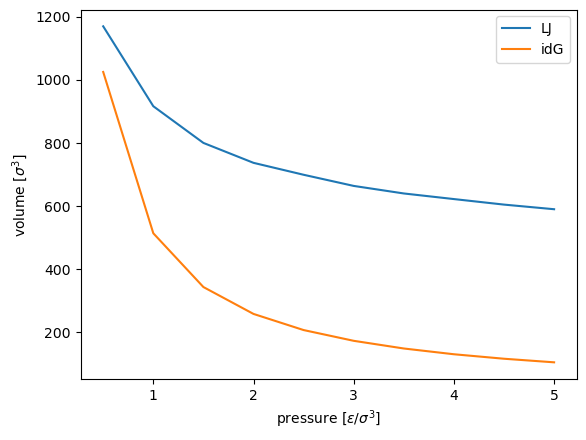

In [9]:
%matplotlib inline
# Display plots within the notebook

from matplotlib import pyplot as plt

V = dict()
V_idg = dict()

for job in project:
    V[job.statepoint()["p"]] = get_volume(job)
    V_idg[job.statepoint()["p"]] = job.document["V"]

p = sorted(V.keys())
V = [V[p_] for p_ in p]
V_idg = [V_idg[p_] for p_ in p]

plt.plot(p, V, label="LJ")
plt.plot(p, V_idg, label="idG")
plt.xlabel(r"pressure [$\epsilon / \sigma^3$]")
plt.ylabel(r"volume [$\sigma^3$]")
plt.legend()
plt.show()

Uncomment and execute the following line to remove all data and start over.

In [10]:
# %rm -r projects/tutorial-signac-flow-hoomd-blue/workspace